In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, minmax_scale
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("Dataset_Diabetes.csv")

#Step 1: Understanding the dataset
#print(df.head())
print(df.info())
#print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 109.5+ KB
None


In [2]:
#Step2: Null
#check for null values even though df.info confirmed there arent any
print(df.isnull().sum())

ID           0
No_Pation    0
Gender       0
AGE          0
Urea         0
Cr           0
HbA1c        0
Chol         0
TG           0
HDL          0
LDL          0
VLDL         0
BMI          0
CLASS        0
dtype: int64


In [3]:
#Step3: Duplicates
#check for duplicated rows
print(df.duplicated().sum())


0


In [4]:
#Step4: Categorical Columns (Class & Gender)
cat_col=df.select_dtypes(include = 'object').columns
print (cat_col)

for col in cat_col:
    print(df[col].unique())

df['Gender'] = df['Gender'].replace({'f':'F'})
df['CLASS'] = df['CLASS'].replace({'N ':'N','Y ':'Y'})

for col in cat_col:
    print(df[col].unique())

Index(['Gender', 'CLASS'], dtype='object')
['F' 'M' 'f']
['N' 'N ' 'P' 'Y' 'Y ']
['F' 'M']
['N' 'P' 'Y']


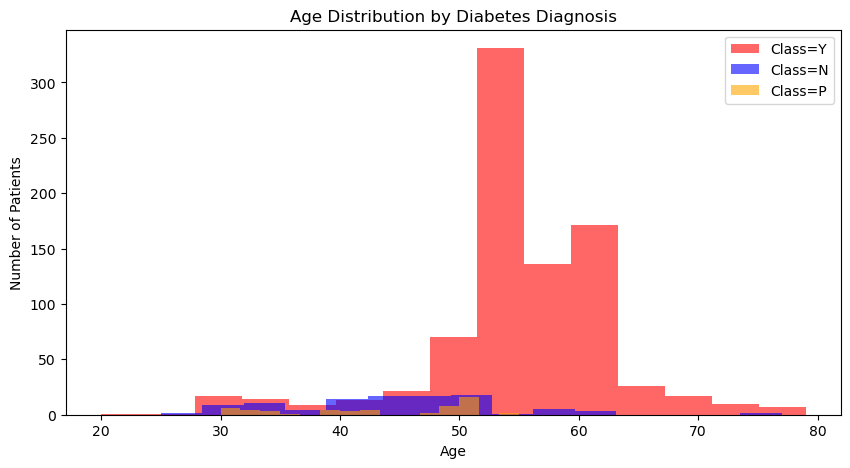

Percent of young diagnosed: 47.73%
Percent of young diagnosed out of the total diagnosed: 4.98%


In [ ]:
#visualization
#Age distribution of diagnosis classes
plt.figure(figsize=(10,5))
for dclass, color in zip(['Y','N','P'],['red','blue','orange']):
    subset = df[df['CLASS']==dclass]
    plt.hist(subset['AGE'], bins=15, alpha=0.6, label=f'Class={dclass}', color=color)
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.title('Age Distribution by Diabetes Diagnosis')
plt.legend()
plt.show()

# What percentage of younger people are prone to be diagnosed with diabetes disease? 
young_cutoff = 40
young = df[df['AGE'] < young_cutoff] #total count of "young" people
young_diabetes = young[young['CLASS']=='Y'] # how many of them are diagnosed
percent_young_diabetes = len(young_diabetes) / len(young) * 100 if len(young) > 0 else None
print(f'Percent of young diagnosed: {percent_young_diabetes:.2f}%')

# how many of the total diagnosed people are considered young?
total_diagnosed = df[df['CLASS']=='Y']
percent_young = len(young_diabetes) / len(total_diagnosed) * 100 if len(young) > 0 else None
print(f'Percent of young diagnosed out of the total diagnosed: {percent_young:.2f}%')

CLASS    N   P    Y
Gender             
F       64  17  354
M       39  36  490
percentage of females out of the total diagnosed 41.94%
percentage of males out of the total diagnosed 58.06%


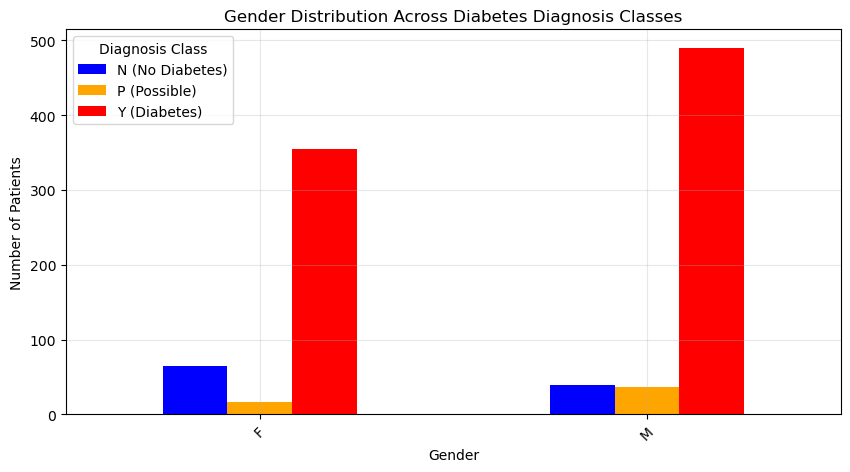

In [6]:
# Group by gender and class to find out which gender is more prone to diabetes
gender_counts = df.groupby(['Gender', 'CLASS']).size().unstack(fill_value=0)
print(gender_counts)

# in percentage:
female_diagnosed_percent = len(df.query("CLASS == 'Y' and Gender == 'F'")) / len(total_diagnosed) * 100
male_diagnosed_percent = len(df.query("CLASS == 'Y' and Gender == 'M'")) / len(total_diagnosed) * 100
print(f'percentage of females out of the total diagnosed {female_diagnosed_percent:.2f}%')
print(f'percentage of males out of the total diagnosed {male_diagnosed_percent:.2f}%')

# Create a grouped bar chart
gender_counts.plot(kind='bar', figsize=(10, 5), color=['blue', 'orange', 'red'])
plt.title('Gender Distribution Across Diabetes Diagnosis Classes')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.legend(title='Diagnosis Class', labels=['N (No Diabetes)', 'P (Possible)', 'Y (Diabetes)'])
plt.xticks(rotation=45)
plt.grid(alpha=0.3)  # Light grid
plt.show()

In [7]:
#now we have consistent values
#label encode Gender
gender_encoder= LabelEncoder()
df['Gender_encoded']=gender_encoder.fit_transform(df['Gender'])
#One hot encode Class
#df=pd.get_dummies(df,columns=['CLASS'],prefix='Class',dtype=int)


#drop id and number of patients because they will distort the results
num_col=df.select_dtypes(exclude='object').columns.drop(['ID', 'No_Pation','Gender_encoded'])
print (num_col)

#print(df)

Index(['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL',
       'BMI'],
      dtype='object')


AGE      98
Urea     65
Cr       52
HbA1c     6
Chol     27
TG       55
HDL      50
LDL      11
VLDL     74
BMI       3
dtype: int64


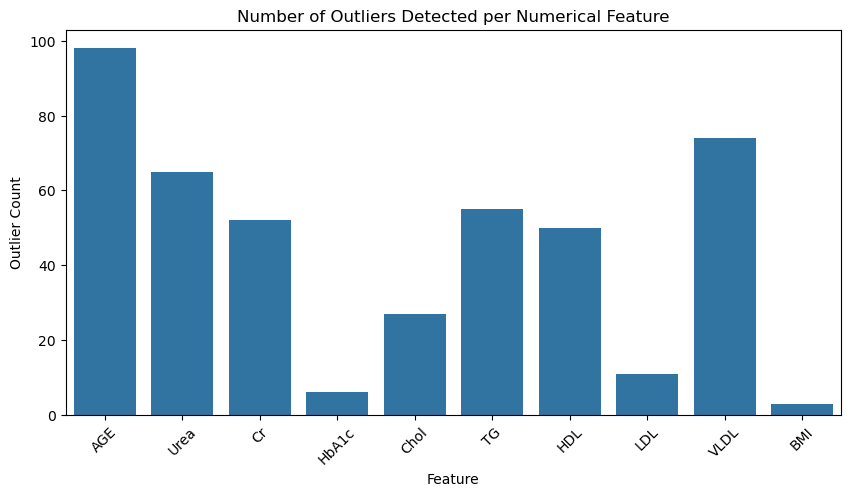

perecentage of outliers per column: 
AGE      9.8
Urea     6.5
Cr       5.2
HbA1c    0.6
Chol     2.7
TG       5.5
HDL      5.0
LDL      1.1
VLDL     7.4
BMI      0.3
dtype: float64


In [8]:
#now we check for outliers
q1= df[num_col].quantile(0.25)
q3 = df[num_col].quantile(0.75)
iqr= q3-q1

outlier_mask = (df[num_col] < (q1 - 1.5 * iqr)) | (df[num_col] > (q3 + 1.5 * iqr))

outlier_counts = outlier_mask.sum()
print(outlier_counts)

# --- Bar Plot of Outlier Counts ---
plt.figure(figsize=(10, 5))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values)
plt.title("Number of Outliers Detected per Numerical Feature")
plt.ylabel("Outlier Count")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.show()

# (Optional) Percentage of outliers per column
outlier_percent = (outlier_counts / len(df) * 100).round(2)
print( "perecentage of outliers per column: ")
print(outlier_percent)


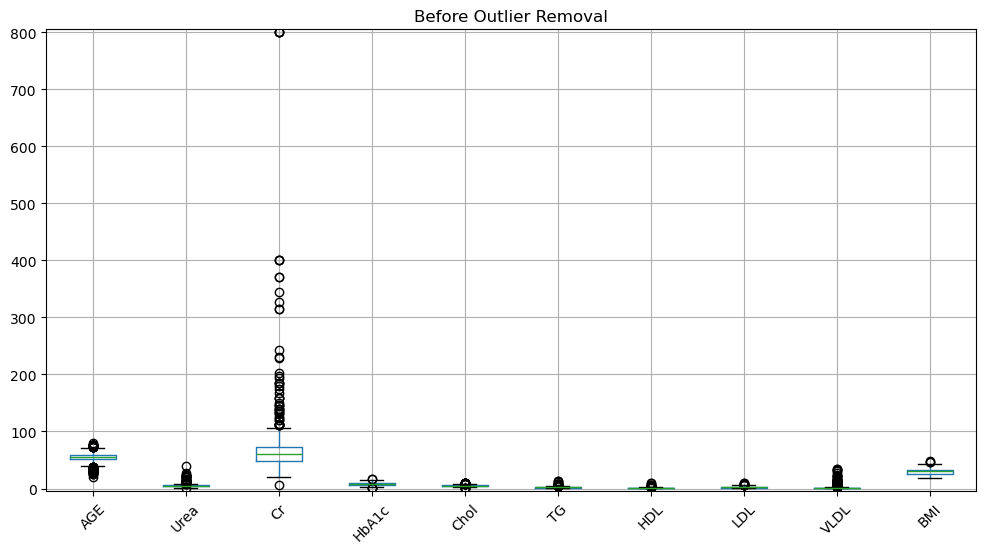

In [9]:
#visualizing the outliers

# Get global min and max from the original (before cleaning) DataFrame
ymin = df[num_col].min().min() -5
ymax = df[num_col].max().max() + 5

# --- Before removing outliers ---
plt.figure(figsize=(12,6))
df[num_col].boxplot()
plt.title("Before Outlier Removal")
plt.ylim(ymin, ymax)  # fix y scale
plt.xticks(rotation=45)
plt.show()


df_cleaned = df[~outlier_mask.any(axis=1)]


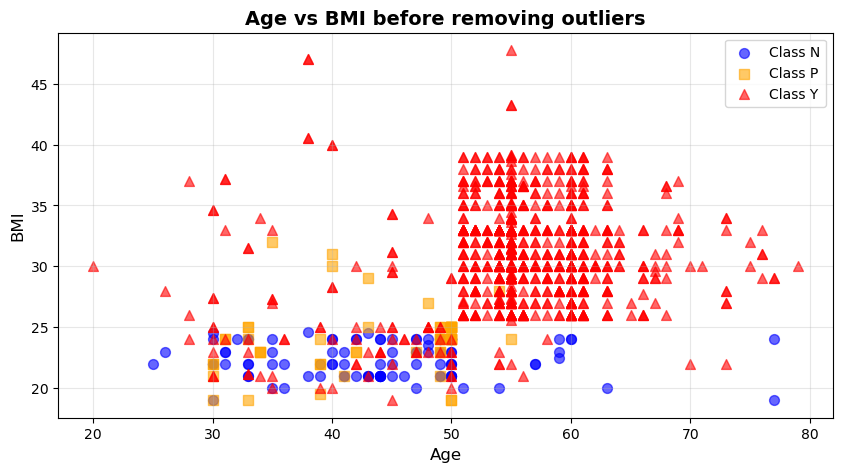

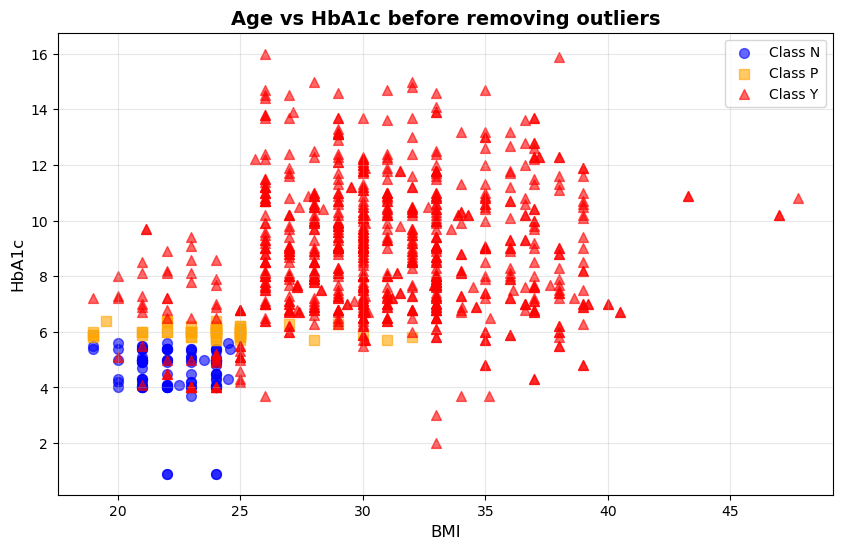

In [10]:
#Scatter plots before removing outliers
# Age vs BMI
plt.figure(figsize=(10, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df[df['CLASS'] == dclass]
    plt.scatter(subset['AGE'], subset['BMI'], 
                alpha=0.6,           # Transparency (0-1) to see overlapping points
                c=color,             # Color for this class
                label=f'Class {dclass}',
                marker=marker,       # Different shapes for each class
                s=50)               # Size of markers

plt.xlabel('Age', fontsize=12)
plt.ylabel('BMI', fontsize=12)
plt.title('Age vs BMI before removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)  # Light grid
plt.show()

# Age vs HbA1c
plt.figure(figsize=(10, 6))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df[df['CLASS'] == dclass]
    plt.scatter(subset['BMI'], subset['HbA1c'], 
                alpha=0.6, c=color, label=f'Class {dclass}', 
                marker=marker, s=50)

plt.xlabel('BMI', fontsize=12)
plt.ylabel('HbA1c', fontsize=12)
plt.title('Age vs HbA1c before removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#from the plot we can see that the Y class (diabetes= yes) often has BMI>25 and Age>50


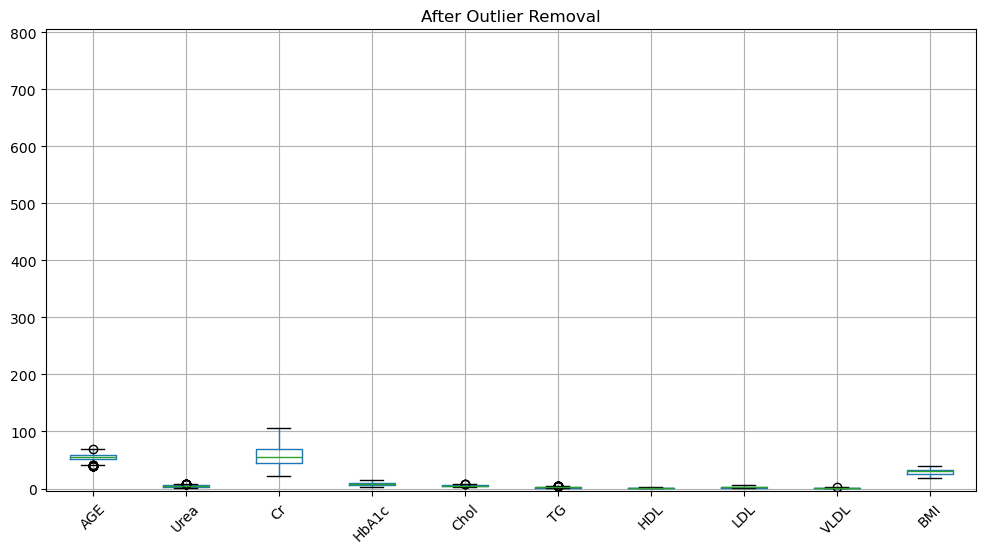

In [11]:
#visualizing after removing outliers
plt.figure(figsize=(12,6))
df_cleaned[num_col].boxplot()
plt.title("After Outlier Removal")
plt.ylim(ymin, ymax)  # same y scale as before
plt.xticks(rotation=45)
plt.show()

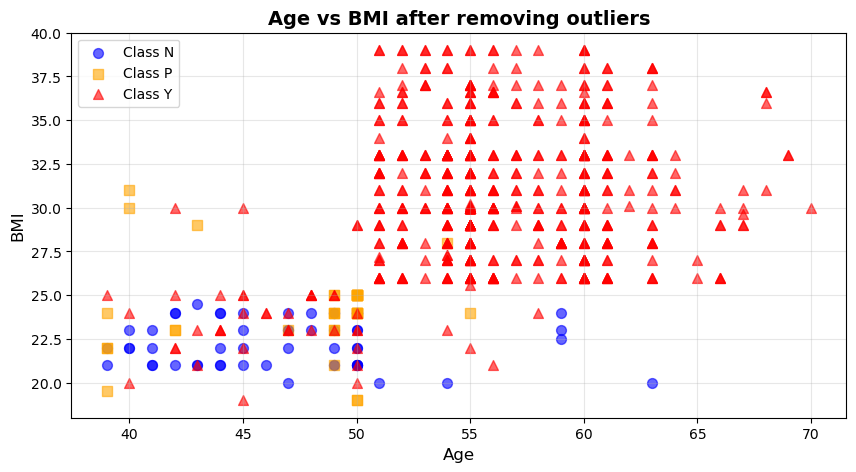

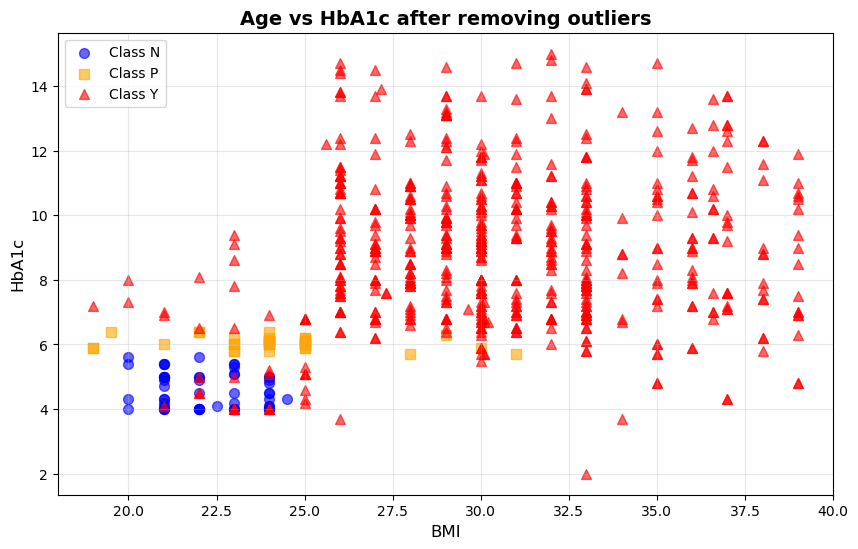

In [12]:
#Scatter plots after removing outliers
# Age vs BMI
plt.figure(figsize=(10, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df_cleaned[df_cleaned['CLASS'] == dclass]
    plt.scatter(subset['AGE'], subset['BMI'], 
                alpha=0.6,           # Transparency (0-1) to see overlapping points
                c=color,             # Color for this class
                label=f'Class {dclass}',
                marker=marker,       # Different shapes for each class
                s=50)               # Size of markers

plt.xlabel('Age', fontsize=12)
plt.ylabel('BMI', fontsize=12)
plt.title('Age vs BMI after removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)  # Light grid
plt.show()

# Age vs HbA1c
plt.figure(figsize=(10, 6))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df_cleaned[df_cleaned['CLASS'] == dclass]
    plt.scatter(subset['BMI'], subset['HbA1c'], 
                alpha=0.6, c=color, label=f'Class {dclass}', 
                marker=marker, s=50)

plt.xlabel('BMI', fontsize=12)
plt.ylabel('HbA1c', fontsize=12)
plt.title('Age vs HbA1c after removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#from the plot we can see that the Y class (diabetes= yes) often has BMI>25 and Age>50


In [13]:
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 679 entries, 5 to 999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              679 non-null    int64  
 1   No_Pation       679 non-null    int64  
 2   Gender          679 non-null    object 
 3   AGE             679 non-null    int64  
 4   Urea            679 non-null    float64
 5   Cr              679 non-null    int64  
 6   HbA1c           679 non-null    float64
 7   Chol            679 non-null    float64
 8   TG              679 non-null    float64
 9   HDL             679 non-null    float64
 10  LDL             679 non-null    float64
 11  VLDL            679 non-null    float64
 12  BMI             679 non-null    float64
 13  CLASS           679 non-null    object 
 14  Gender_encoded  679 non-null    int64  
dtypes: float64(8), int64(5), object(2)
memory usage: 84.9+ KB
None


C:\Users\ayaya\AppData\Local\Temp\ipykernel_2956\2921729815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[num_col] = scaler.fit_transform(df_cleaned[num_col])


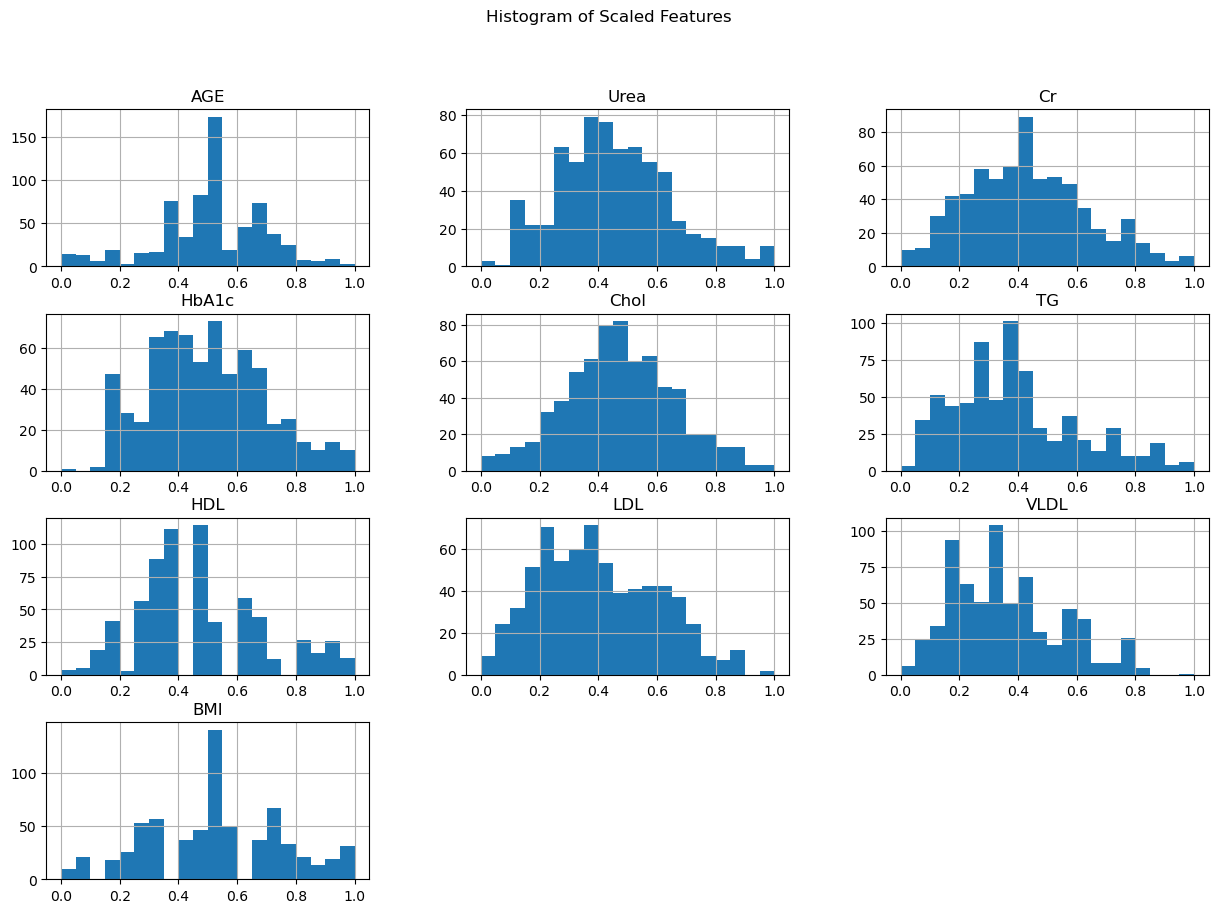

In [14]:
#now scaling
scaler=MinMaxScaler()
df_cleaned[num_col] = scaler.fit_transform(df_cleaned[num_col])
df_cleaned[num_col].describe()

df_cleaned[num_col].hist(bins=20, figsize=(15,10))
plt.suptitle("Histogram of Scaled Features")
plt.show()

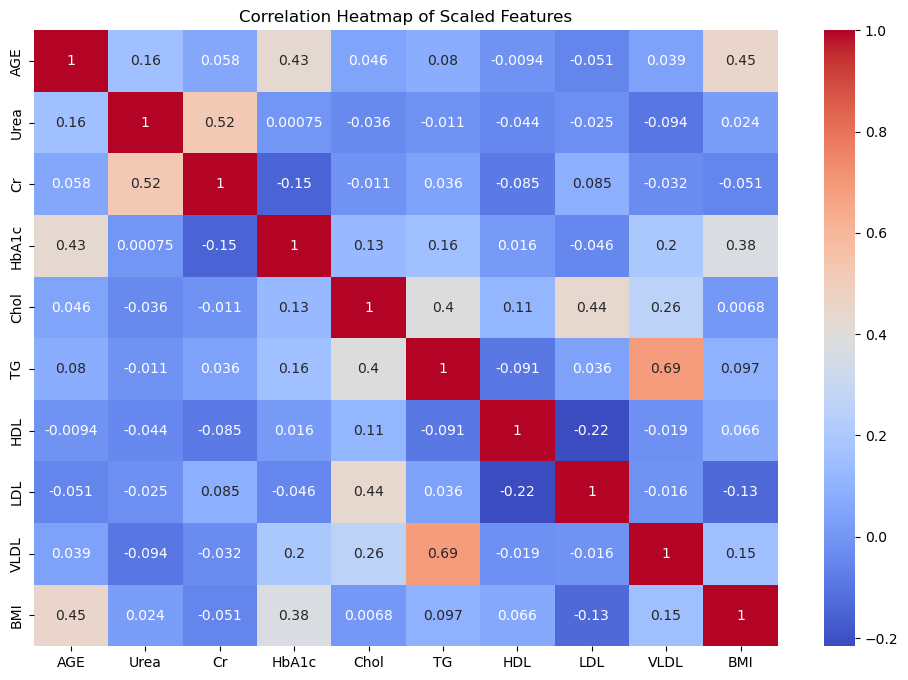

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(df_cleaned[num_col].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Scaled Features")
plt.show()